In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Plot standing data
standing = pd.read_csv('../data/standing.txt', header=None)
standing.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

walking= pd.read_csv('../data/walking.txt', header=None)
walking.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

briskwalk = pd.read_csv('../data/briskwalk.txt', header=None)
briskwalk.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']



<h1> Action Detection algorithm </h1>

<h2> Standing </h2
>

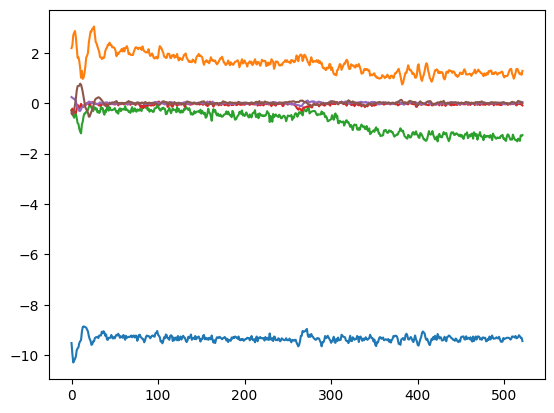

In [2]:
column_names = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

for column in column_names:
    plt.plot(standing[column], label='standing')

<h1> Walking </h1>

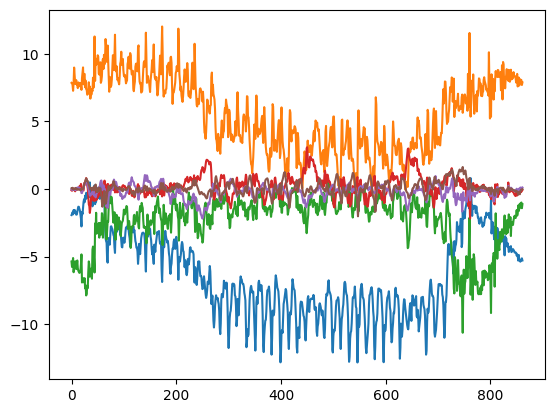

In [3]:
for column in column_names:
    plt.plot(walking[column], label='walking')

<h1> Brisk-walk </h1>


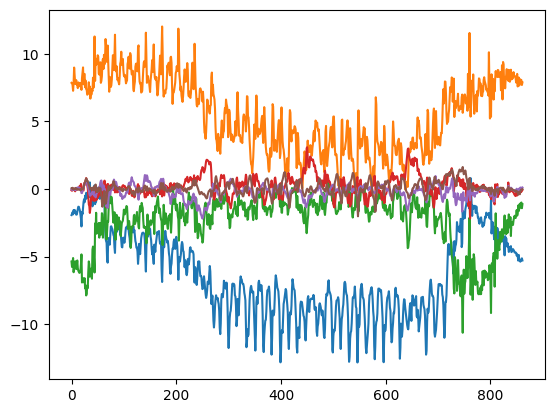

In [4]:
for column in column_names:
    plt.plot(walking[column], label='walking')

## Applying to FPGA with sample

Here we will alternate between four different actions

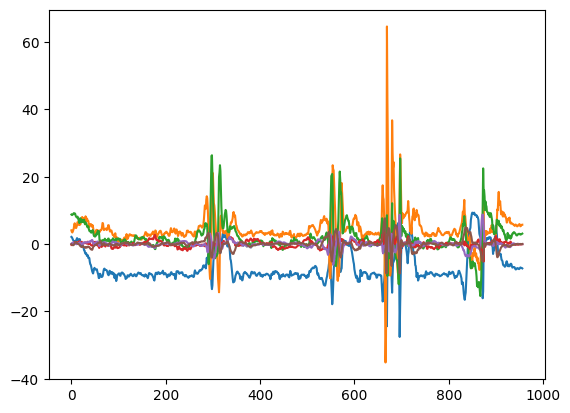

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'walk_to_doctor_strange.txt'
data = pd.read_csv(filename, sep=',', header=None)
data.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

plt.plot(data['Acc_X'])
plt.plot(data['Acc_Y'])
plt.plot(data['Acc_Z'])
plt.plot(data['Gyr_X'])
plt.plot(data['Gyr_Y'])
plt.plot(data['Gyr_Z'])

# Plot noticeable spikes
def plot_spikes(data, col, threshold):
    plt.plot(data[col])
    plt.plot(data[col][data[col] > threshold], 'ro')
    plt.show()
    


## Determining simple threshold algorithm

Now that we can identify certain spikes in between the no-actions and the actions, we can determine a simple algorithm that pin-points a start of action, or rather a sudden movement.

The actual threshold can be easily determined with enough datapoints, but from here on we demonstrate the same working on a smaller dataset

The threshold calculation is as follows:

$Val = \delta_{max}(Acc_X) + \delta_{max}(Acc_Y) + \delta_{max}(Acc_Z) $
And we detect a start of action when $Val \geq Threshold$

In [6]:

def get_threshold(sequence):
    # return max change of Acc_X, Acc_Y, Acc_Z, Gyr_X, Gyr_Y, Gyr_Z
    # assume that the sequence is a pandas dataframe
    max_acc_x = np.max(np.abs(np.diff(sequence['Acc_X'])))
    max_acc_y = np.max(np.abs(np.diff(sequence['Acc_Y'])))
    max_acc_z = np.max(np.abs(np.diff(sequence['Acc_Z'])))
 
    
    return sum([max_acc_x, max_acc_y, max_acc_z])


## Applying algorithm to a sequence

As we are dealing with sequential data, and we have determined a suitable window size = 50 frames, for an action, we can safely use a sliding window size of 25 frames to 'capture' a peak of a sequence.

Then, the 25 frames and the next 25 frames could be sent as a packet for classification

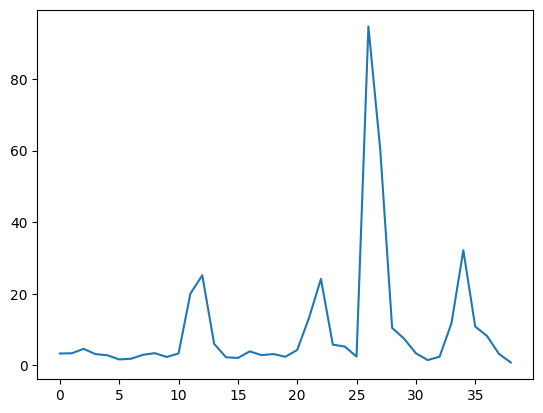

In [7]:
# run get_threshold on all sequence of 25 frames for data
thresholds = []
for i in range(0, data.shape[0], 25):
    thresholds.append(get_threshold(data[i:i+25]))
    
plt.plot(thresholds)


### Threshold visualisation

We can also verify that non-actions would not trigger the threshold

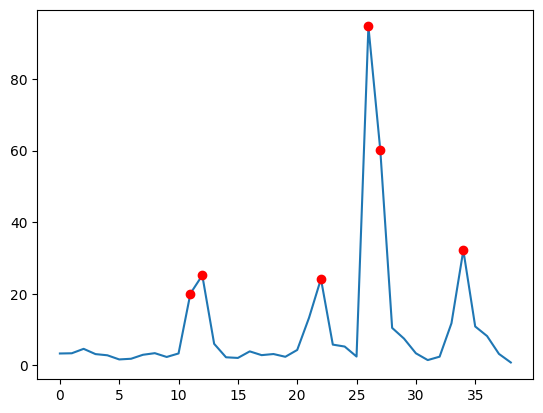

In [8]:
# estimate number of spikes
#count number of times threshold reaches 20
n_spikes = 0
sequence_markers = []
for i in range(len(thresholds)):
    # if magnitude of threshold_diff is greater than 20
    if abs(thresholds[i]) > 20:
        n_spikes += 1
        sequence_markers.append(i)
        
# replot thresholds with markers
plt.plot(thresholds)
plt.plot(sequence_markers, [thresholds[i] for i in sequence_markers], 'ro')


Text(0, 0.5, 'Threshold')

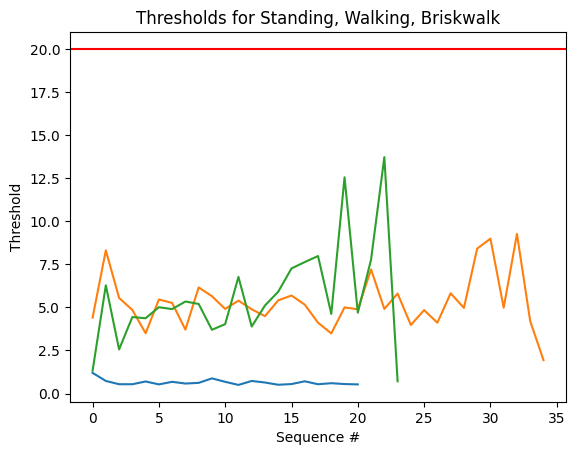

In [9]:
#try with standing/ walking dataset
filename = '../data/standing.txt'
standing = pd.read_csv(filename, sep=',', header=None)
standing.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

filename = '../data/walking.txt'
walking = pd.read_csv(filename, sep=',', header=None)
walking.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

filename = '../data/briskwalk.txt'
briskwalk = pd.read_csv(filename, sep=',', header=None)
briskwalk.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

thresholds_standing = []
# get threshold for standing
for i in range(0, standing.shape[0], 25):
    thresholds_standing.append(get_threshold(standing[i:i+25]))
    
plt.plot(thresholds_standing)

thresholds_walking = []
# get threshold for walking
for i in range(0, walking.shape[0], 25):
    thresholds_walking.append(get_threshold(walking[i:i+25]))
    
plt.plot(thresholds_walking)

thresholds_briskwalk = []
# get threshold for briskwalk
for i in range(0, briskwalk.shape[0], 25):
    thresholds_briskwalk.append(get_threshold(briskwalk[i:i+25]))
    
plt.plot(thresholds_briskwalk)

# plot horizontal line signifiying threshold of 20
plt.axhline(y=20, color='r', linestyle='-')

# label the plot
plt.title('Thresholds for Standing, Walking, Briskwalk')
plt.xlabel('Sequence #')
plt.ylabel('Threshold')


### Window visualisation

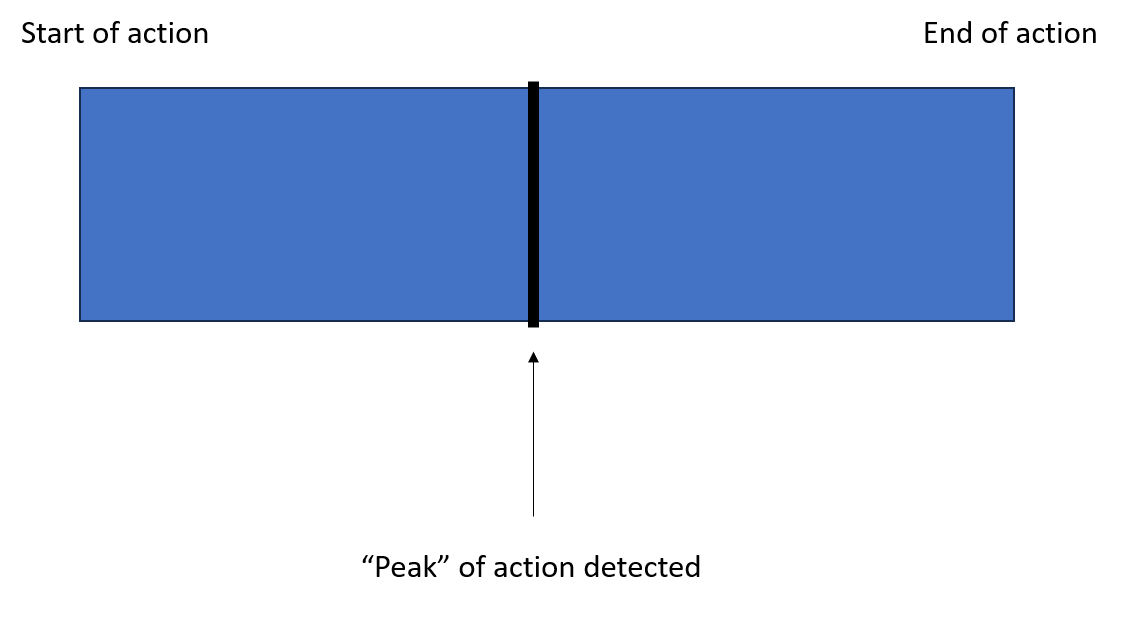

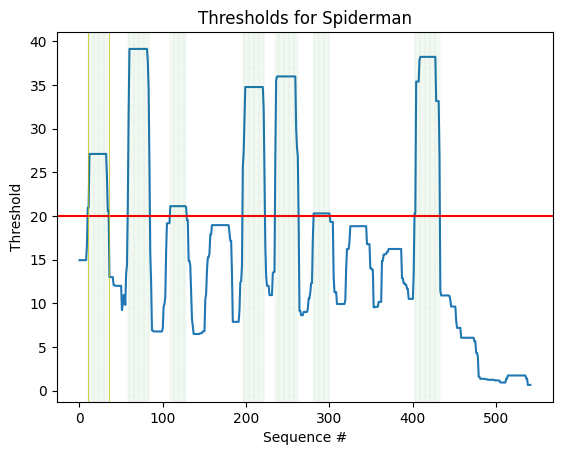

In [10]:
import pandas as pd
import numpy as np

spiderman = pd.read_csv('../data/spiderman.txt', header=None)
spiderman.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

# get sliding window of 25 frames - rehash from hwai_notes notebook
def gen_sequence(df, seq_length, seq_cols):
    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
sequence_cols = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

seq_len = 25

seq_gen = (list(gen_sequence(spiderman, seq_len, sequence_cols)))
seq_gen = np.stack(list(seq_gen)).astype(np.float32)

thresholds = []
for seq in seq_gen:
    seq_df = pd.DataFrame(seq)
    seq_df.columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']
    thresholds.append(get_threshold(seq_df))

plt.plot(thresholds)
plt.xlabel('Sequence #')
plt.ylabel('Threshold')

# label plot as spiderman
plt.title('Thresholds for Spiderman')

# plot horizontal line signifiying threshold of 20
plt.axhline(y=20, color='r', linestyle='-')

# plot y line when threshold is greater than 20
for i in range(len(thresholds)):
    if thresholds[i] > 20:
        plt.axvline(x=i, color='g', linestyle='--', linewidth=0.05)

# plot x = 10 for start of threshold hit
plt.axvline(x=10, color='y', linestyle='-', linewidth=0.5)

# plot x = 35 for end of threshold hit
plt.axvline(x=35, color='y', linestyle='-', linewidth=0.5)

From the above figure, we can approximate a sampling window of 25 frames, twice our sliding window of 50 frames for action detection.

The framework would thus be to have an initial queue of 25 frames which would continously be refreshed using a window overlap of 1/25 frames.

For instance, using {#} as the frame count and [] as the example data (which would be Acc_XYZ, Gyr_XYZ and the engineered features),



> at timestamp t1 = 0s

 [1,2,3,4,5]{1}[1,2,3,4,5]{2}...[1,2,3,4,5]{25}

> at timestamp t2 = 0s + sampling period

 [2,3,4,5,6]{1}[2,3,4,5,6]{2}...[2,3,4,5,6]{25}

Note that all but 1 of the values should be identical from t2 to t1, this is called window overlap

Only when the threshold is hit, then we populate the next 25 frames

>  [2,3,4,5,6]{1}[2,3,4,5,6]{2}...[2,3,4,5,6]{50}

Which would be sent to the classification algorithm which is trained on 50 frames